# Prepared sweep signals

Here is examples of prepared sweeps. You can check imported functions and build own.

Required import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sweep_design import (Spectrum, ApriorUncalculatedSweep, 
                            ArrayAxis, Relation, Signal, Sweep)
from sweep_design.prepared_sweeps import (get_linear_sweep, get_shuffle, 
                get_m_sequence_code, get_code_zinger, get_code_sweep_segments,
                get_convolution_sweep_and_code)
from sweep_design.utility_functions import dwell, tukey_a_t, get_IMFs_emd


Preparation

In [3]:
def plot_sweep(sweep_signal: Sweep):
    figure, axis = plt.subplots(5, 1, constrained_layout=True, figsize=(10,10)) # change figsize if rendering issues.
    axis[0].plot(*sweep_signal.get_data())
    axis[0].set_title("Sweep")
    axis[0].set_xlabel("Time, s")
    axis[0].set_ylabel("Amplitude")

    axis[1].plot(*sweep_signal.frequency_time.get_data())
    axis[1].set_title("Frequency modulation")
    axis[1].set_xlabel("Time, s")
    axis[1].set_ylabel("Frequency, Hz")

    axis[2].plot(*sweep_signal.amplitude_time.get_data())
    axis[2].set_title("Amplitude modulation")
    axis[2].set_xlabel("Time, s")
    axis[2].set_ylabel("Amplitude")

    axis[3].plot(*sweep_signal.get_amplitude_spectrum().get_data())
    axis[3].set_title("Amplitude spectrum")
    axis[3].set_xlabel("Frequency, Hz")
    axis[3].set_ylabel("Amplitude")

    axis[4].plot(*sweep_signal.get_phase_spectrum().get_data())
    axis[4].set_title("Phase spectrum")
    axis[4].set_xlabel("Frequency, Hz")
    axis[4].set_ylabel("Phase")



In [2]:
sample = 0.00025
time_axis = ArrayAxis(0., 15., sample)
tukey_amp = Relation(time_axis, tukey_a_t(time_axis.array, 1))
small_time = ArrayAxis(0., 4., sample)
small_linear_sweep = get_linear_sweep(small_time, 3, 98, 0.5)


## Linear sweep

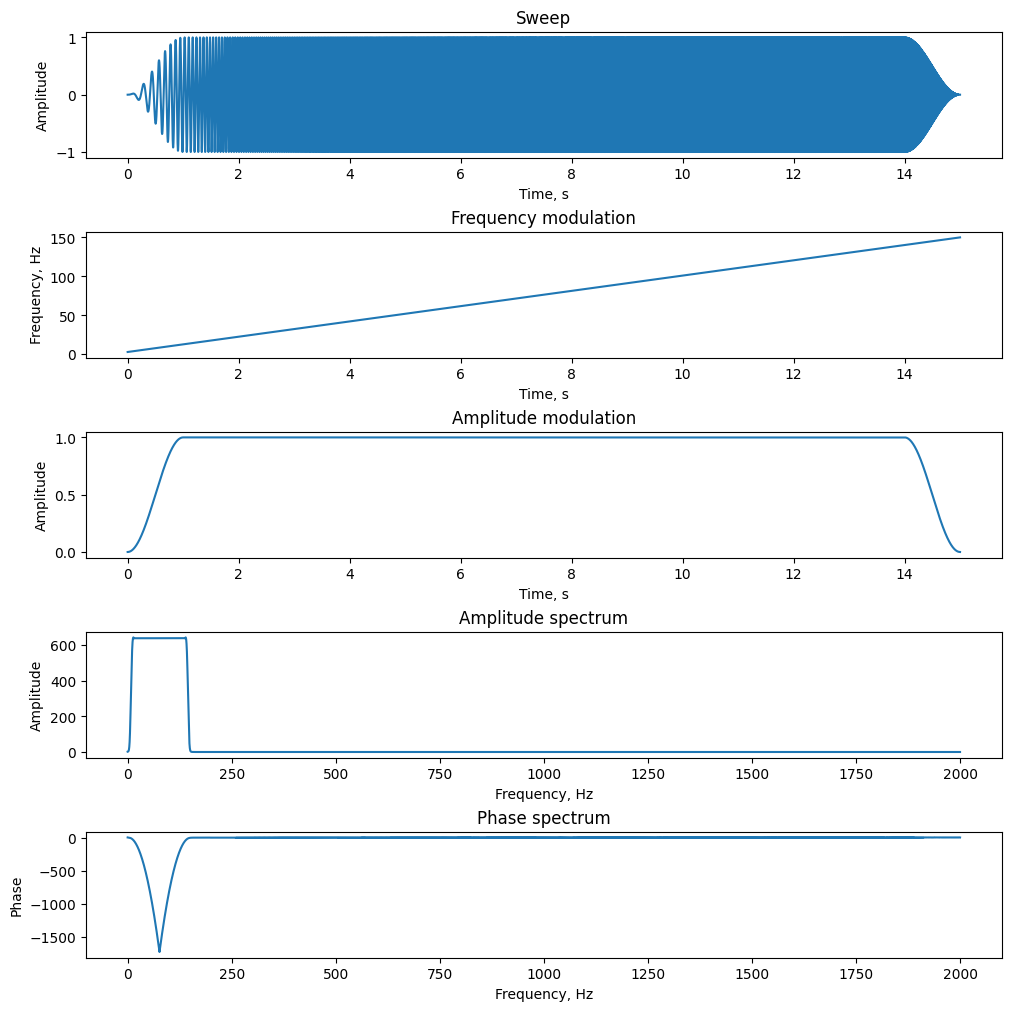

In [5]:
linear_sweep = get_linear_sweep(time_axis, 3, 150, 1)
plot_sweep(linear_sweep)


## Dwell sweep

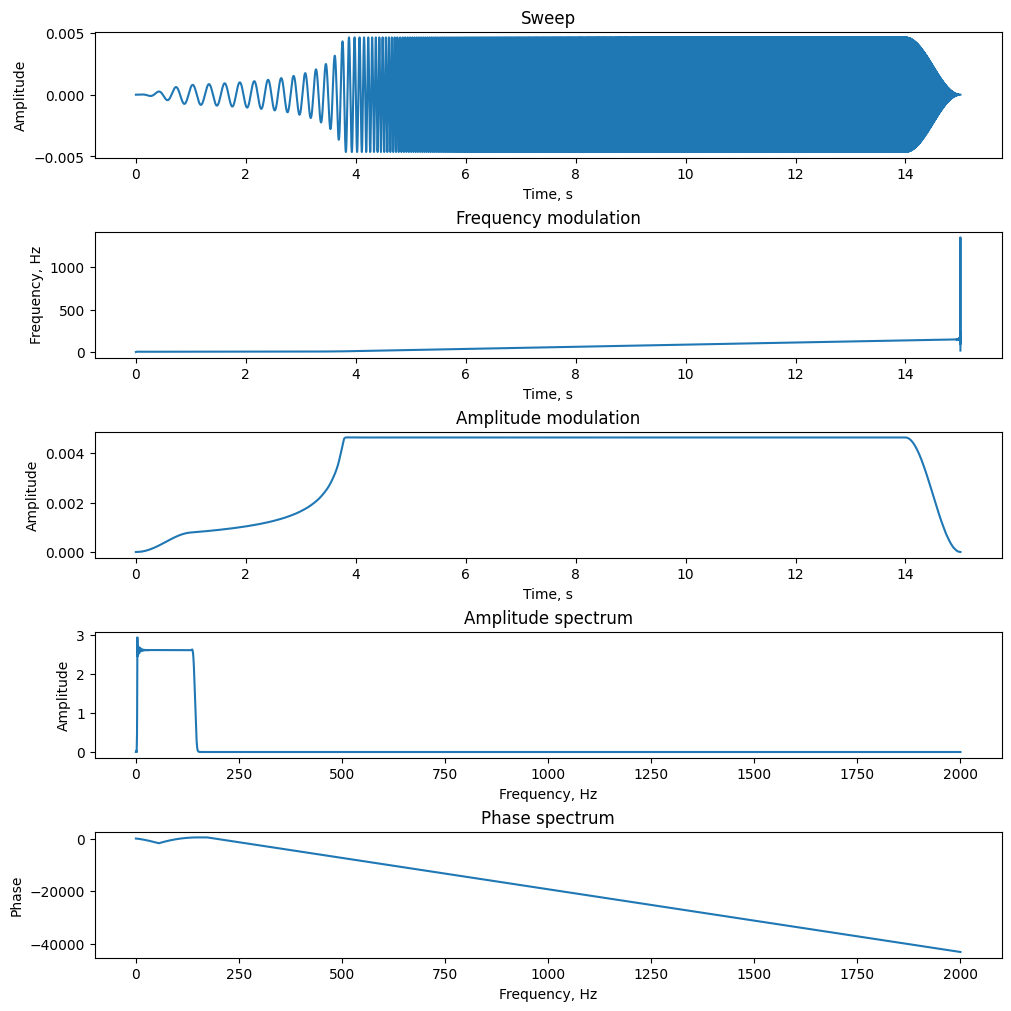

In [11]:
frequency = ArrayAxis(3., 150., 0.001)
spectrum = Spectrum(frequency, np.ones(frequency.size))
uncalculated_dwell_sweep = ApriorUncalculatedSweep(
    time_axis, spectrum, dwell(3, 150, 8))
dwell_sweep = uncalculated_dwell_sweep() * tukey_amp
plot_sweep(dwell_sweep)

## Shuffle sweep

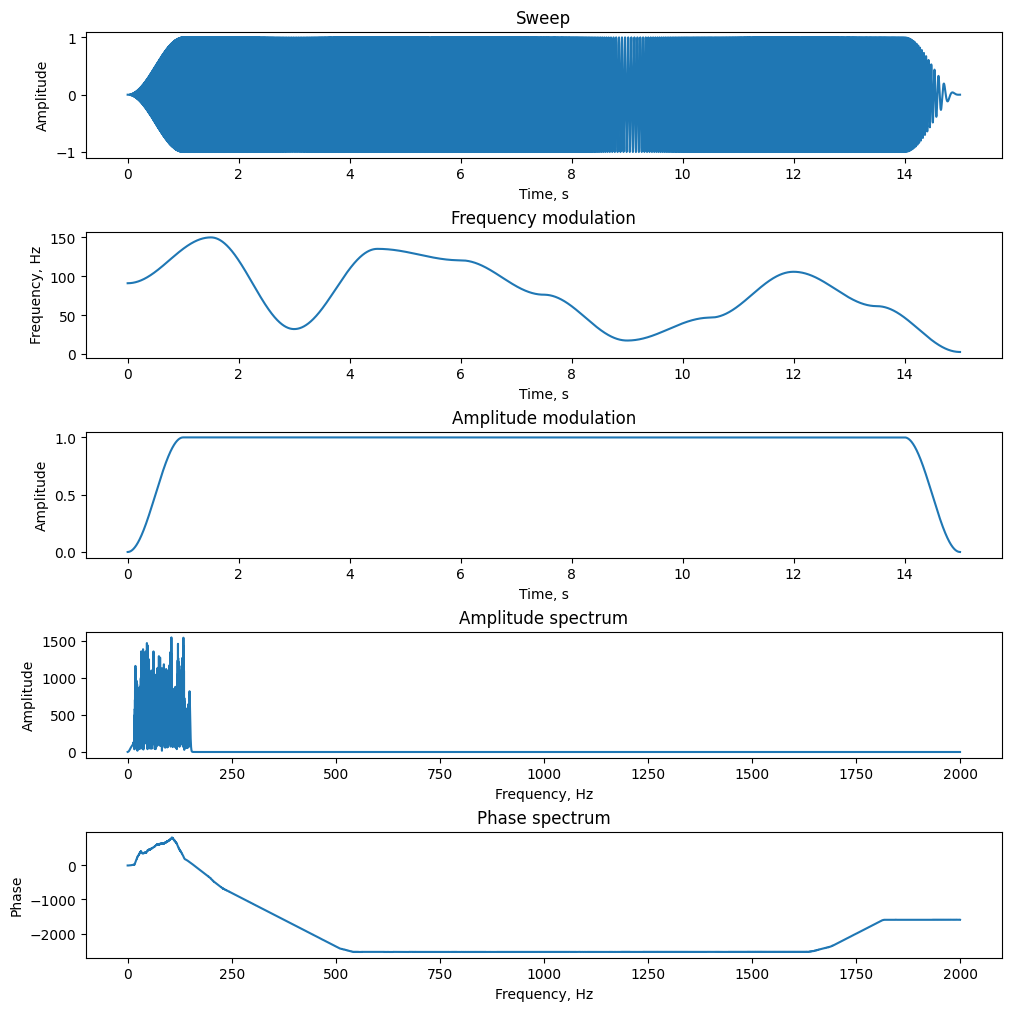

In [10]:
shuffle_sweep = get_shuffle(time_axis, 3, 150, 1.5, time_tapper=1)
plot_sweep(shuffle_sweep)

## m-sequence convolve

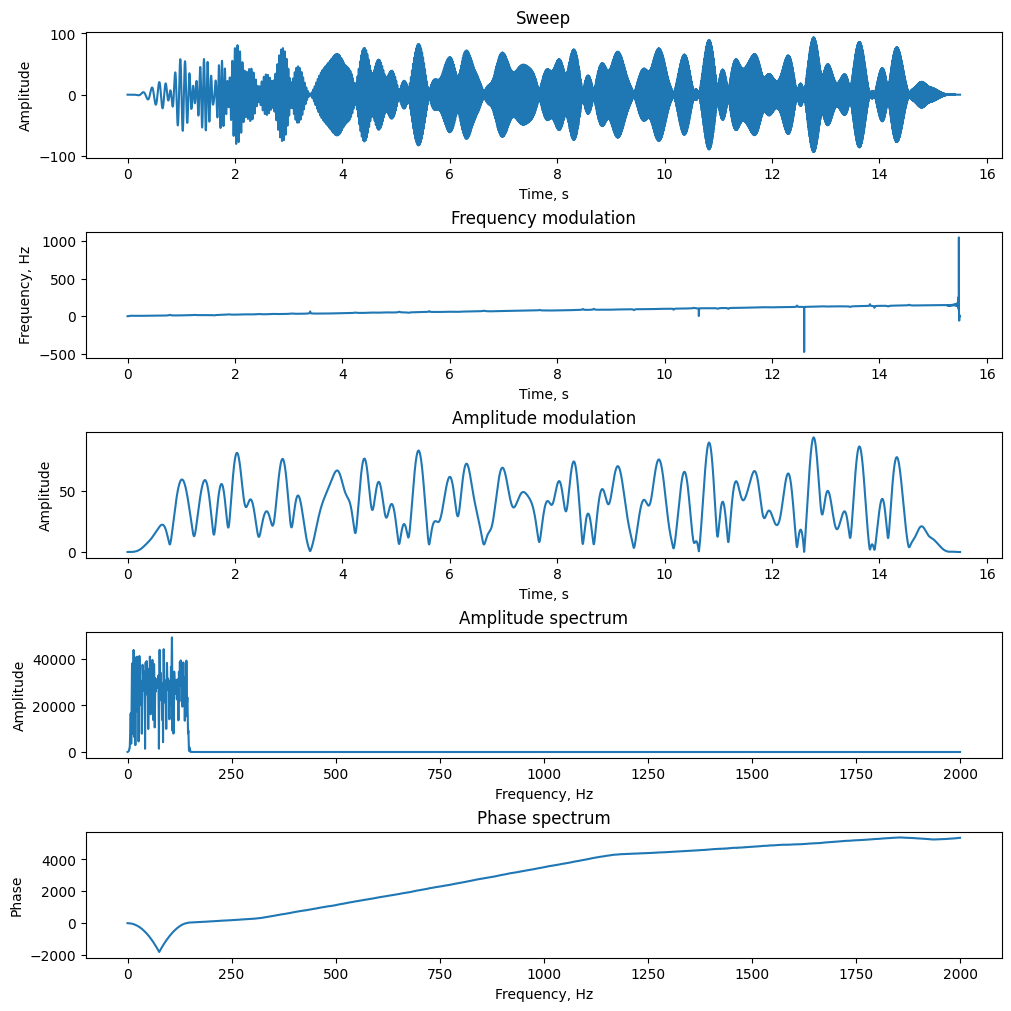

In [6]:
length_sequence = 2000
m_sequence_code = get_m_sequence_code(length_sequence) * 2 - 1
correlate_m_sequence_sweep = get_convolution_sweep_and_code(
    m_sequence_code, linear_sweep)
plot_sweep(correlate_m_sequence_sweep)

## m-sequence code

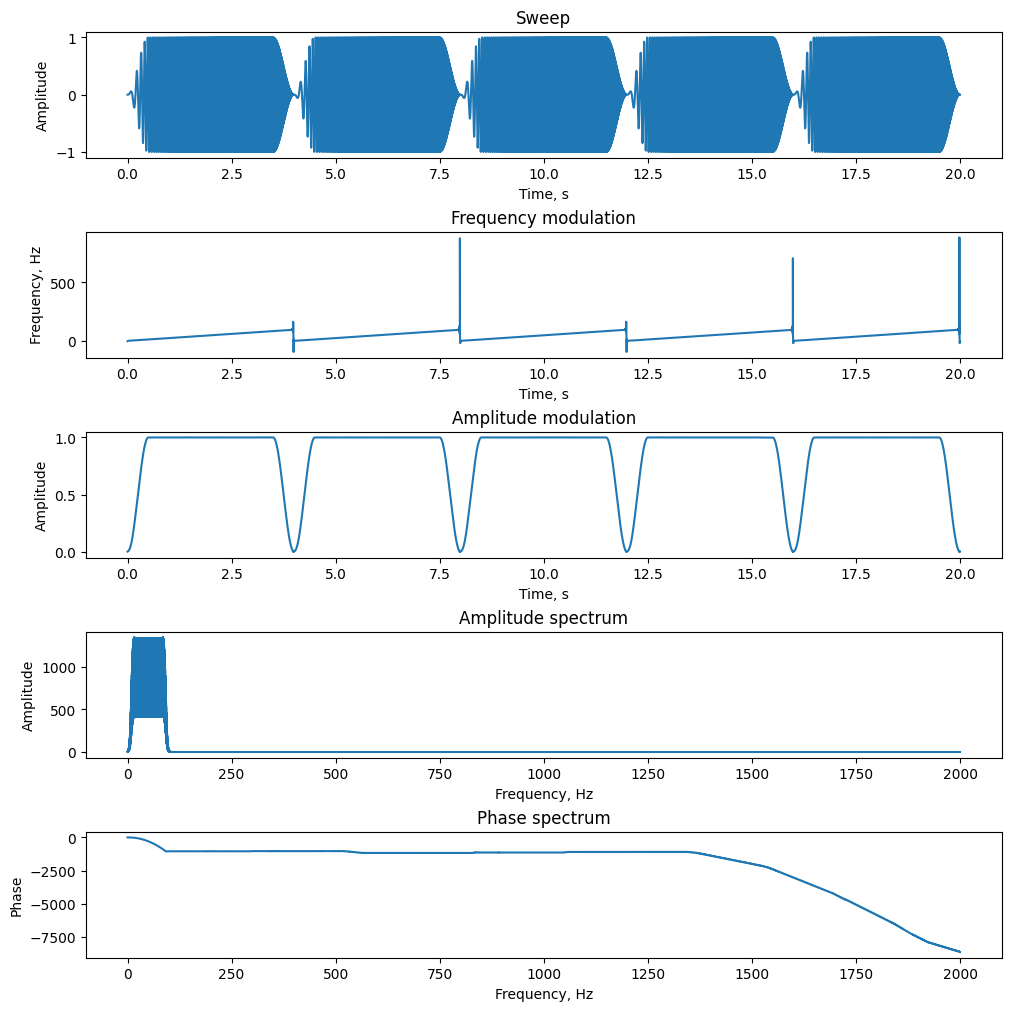

In [9]:
length_sequence = 6
m_sequence_code_2 = get_m_sequence_code(length_sequence) * 2 - 1
code_m_sequence_sweep = get_code_sweep_segments(
    m_sequence_code_2, small_linear_sweep)

plot_sweep(code_m_sequence_sweep)

## pure m-sequence

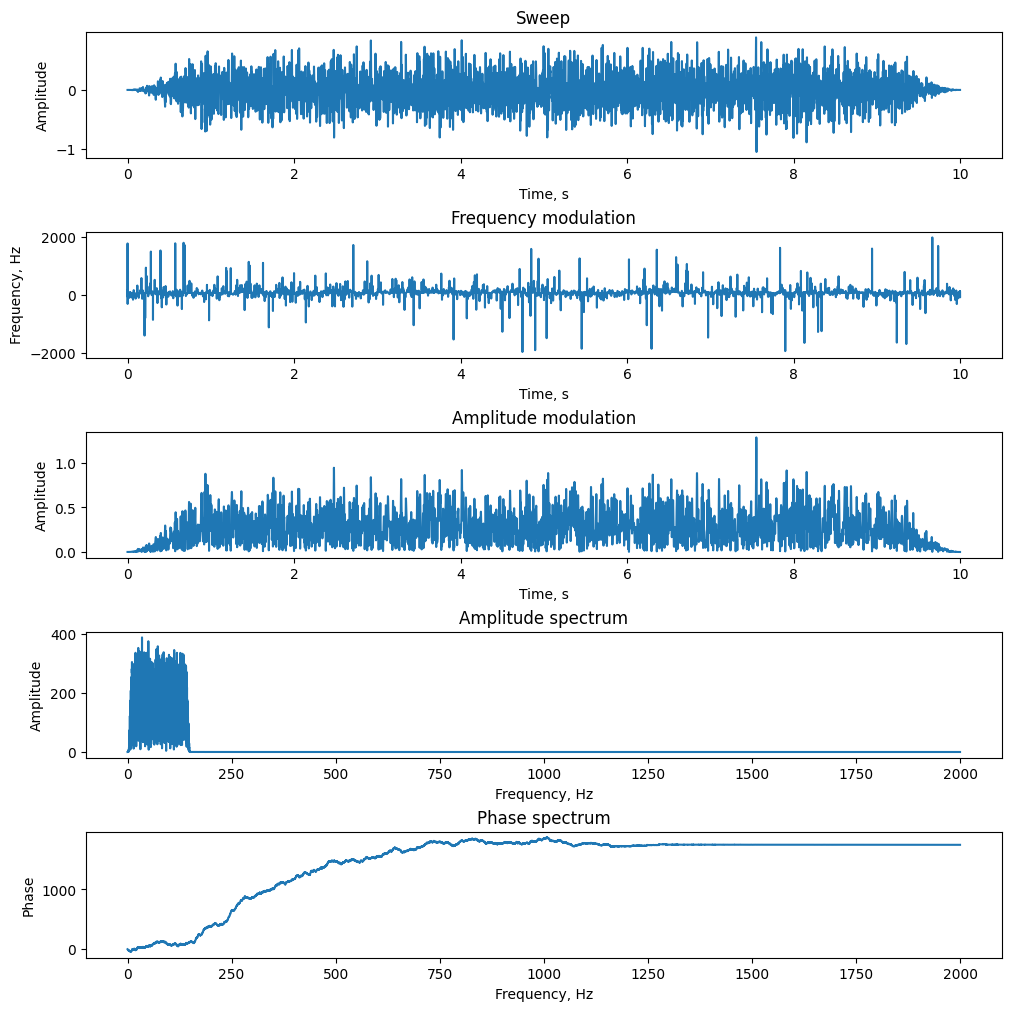

In [8]:
time_10 = ArrayAxis(0., 10., sample)
m_sequence_code_3 = get_m_sequence_code(time_10.size + 1)

m_sequence_signal = Signal(time_10, m_sequence_code_3 * 2 - 1)
m_sequence_amp_spectrum = m_sequence_signal.get_amplitude_spectrum()
m_sequence_phase_spectrum = m_sequence_signal.get_phase_spectrum()
f = m_sequence_amp_spectrum.x
filter_axis = ArrayAxis(f.start, 150, f.sample)
filter_array = tukey_a_t(filter_axis.array, 10)
filter_ = Relation(filter_axis, filter_array)
m_sequence_amp_spectrum_filter = m_sequence_amp_spectrum * filter_

filtered_m_sequence_spectrum = Spectrum.get_spectrum_from_amp_phase(
    m_sequence_amp_spectrum_filter, m_sequence_phase_spectrum)
filtered_m_sequence_signal = filtered_m_sequence_spectrum.get_signal()

displacement = filtered_m_sequence_signal.integrate().integrate()
imfs = get_IMFs_emd(displacement)
new_displacement = sum(imfs[:-1])

tukey_amp_10 = Relation(time_10, tukey_a_t(time_10.array, 1))
corrected_m_sequence = (new_displacement * tukey_amp_10).diff().diff()
corrected_m_sequence = Sweep(corrected_m_sequence)

plot_sweep(corrected_m_sequence)


## code zinger

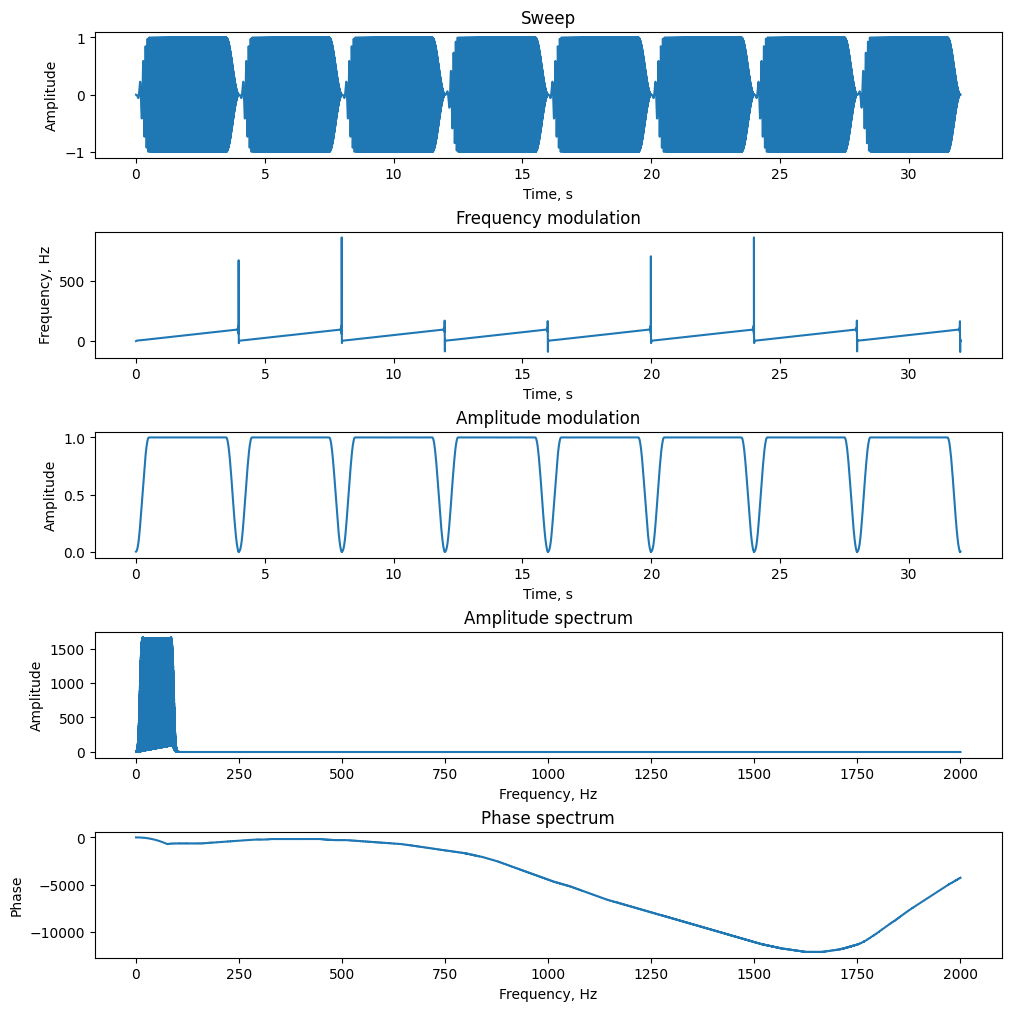

In [7]:
code_zinger = get_code_zinger(periods=2)
code_zinger_sweep = get_code_sweep_segments(code_zinger, small_linear_sweep)

plot_sweep(code_zinger_sweep)